# Offline Path Planning Optimization by Segmented Bezier Curves

This notebook demonstrates a practical example of path planning using Bezier curves in each segment. In both explored approaches, a single Bezier curve is fit within each segment. The control points are then determined to obtain a path of minimum curvature, curvature variation with curvature continuity.

![](figures/cubic_segment.png)

In [142]:
import time
import nlopt
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import scipy.special
from optimparallel import minimize_parallel
from cubic_bezier_planner import calc_bezier_path
from cubic_spline_planner import calc_spline_course

In [143]:
class Path:
    def __init__(self, x, y, yaw, k):
        self.x = x
        self.y = y
        self.yaw = yaw
        self.k = k

## Calculating Bezier Curve Control Points

### Cubic Bezier Path
A cubic Bezier path requires 4 control points, solved by being input the start and end conditions in position and yaw. The offset expresses the distance from each endpoint to middle control points as a fraction of the segment length.


In [144]:
"""
Compute control points and path given start and end conditions in yaw and position for a cubic bezier spline
"""
def calc_4points_bezier_path(sx, sy, syaw, ex, ey, eyaw, offset_1, offset_2):

    dist_1 = np.hypot(sx - ex, sy - ey) * offset_1 * 0.5
    dist_2 = np.hypot(sx - ex, sy - ey) * offset_2 * 0.5

    control_points = np.array(
        [[sx, sy],
         [sx + dist_1 * np.cos(syaw), sy + dist_1 * np.sin(syaw)],
         [ex - dist_2 * np.cos(eyaw), ey - dist_2 * np.sin(eyaw)],
         [ex, ey]])

    path = calc_bezier_path(control_points, n_points=170)
    return path, control_points

# Spline Class
A spline class is initated with an input set of waypoints and a maximum deviation. Boundary lines are constructed, and this class features functions for calculating derivatives, yaw, curvature and path distance.

In [145]:
class Spline():

    def __init__(self, ax, ay, bound):
        
        #input waypoint coordinates
        ayaw, k = self.calc_yaw_curvature(ax, ay)
        self.waypoints = Path(ax, ay, ayaw, k)
        
        # defines and sets left and right boundary lines
        self.bound = bound
        lax, lay, rax, ray = self.init_boundary()
        self.left_bound = Path(lax, lay, None, None)
        self.right_bound = Path(rax, ray, None, None)

        # default unoptimized cubic bezier path to initialize curvature
        bx, by, _, _, _ = self.cubic_bezier_path(ax, ay, [], [])
        byaw, bk = self.calc_yaw_curvature(bx, by)
        self.default_path = Path(bx, by, byaw, bk)

        # default seeding path for cubic spline
        cx, cy, cyaw, ck, _ = calc_spline_course(ax, ay, 0.5)
        self.seeding_path = Path(cx, cy, cyaw, ck)

        self.optimized_path = Path([], [], [], [])
        self.ctr_points = Path([], [], [], [])

    # Calculates the first derivative of input arrays
    def calc_d(self, x, y):

        dx, dy = [], []

        for i in range(0, len(x)-1):
            dx.append(x[i+1] - x[i])
            dy.append(y[i+1] - y[i])
        
        dx.append(dx[-1])
        dy.append(dy[-1])
        return dx, dy

    # Calculates yaw and curvature given input path
    def calc_yaw_curvature(self, x, y):

        dx, dy = self.calc_d(x,y)
        ddx, ddy = self.calc_d(dx, dy)
        yaw = []
        k = []

        for i in range(0, len(x)):
            yaw.append(math.atan2(dy[i], dx[i]))
            k.append( (ddy[i] * dx[i] - ddx[i] * dy[i]) / ((dx[i]**2 + dy[i]**2)**(3/2)) )
    
        return yaw, k

    # Calculates total distance of the path
    def calc_path_dist(self, x, y):

        dx = np.absolute(self.calc_d(np.zeros(len(x)), x))
        dy = np.absolute(self.calc_d(np.zeros(len(y)), y))
        ddist = np.hypot(dx, dy)

        return np.sum(ddist)


    # Determines position of boundary lines for visualization
    def init_boundary(self):

        rax, ray, lax, lay = [], [], [], []

        for n in range(0, len(self.waypoints.yaw)):
            lax.append(self.waypoints.x[n] - self.bound*np.sin(self.waypoints.yaw[n]))
            lay.append(self.waypoints.y[n] + self.bound*np.cos(self.waypoints.yaw[n]))
            rax.append(self.waypoints.x[n] + self.bound*np.sin(self.waypoints.yaw[n]))
            ray.append(self.waypoints.y[n] - self.bound*np.cos(self.waypoints.yaw[n]))
        
        return lax, lay, rax, ray



## Piecewise Bezier Curve Interpolation Through Waypoints

### Determining Heading Conditions
The heading condition at each waypoint is determined as the normal to the bisector of the angle formed from the 2 adjacent waypoints.
https://users.soe.ucsc.edu/~elkaim/Documents/camera_WCECS2008_IEEE_ICIAR_58.pdf

In [146]:
class Spline(Spline):

    # Bezier path one as per the approach suggested in
    # https://users.soe.ucsc.edu/~elkaim/Documents/camera_WCECS2008_IEEE_ICIAR_58.pdf
    def cubic_bezier_path(self, ax, ay, offset_1, offset_2):

        dyaw, _ = self.calc_yaw_curvature(ax, ay)

        if (len(offset_1) == 0 or len(offset_2) == 0):
            offset_1 = []
            offset_2 = []
            for n in range(len(ax)-1):
                offset_1.append(0.7)
                offset_2.append(0.7)

        k_1 = []            # start curvatures, assuming subsequent path starts with 0.0
        k_2 = [0.0]         # end curvatures, assuming prior path ends with 0.0
        eval_range = 10      # range of points to evaluate curvature

        # control point and path array
        cx, cy, ctr_pt_x, ctr_pt_y = [], [], [], []

        ayaw = dyaw.copy()

        for n in range(1, len(ax)-1):
            yaw = 0.5*(dyaw[n] + dyaw[n-1])
            ayaw[n] = yaw

        # for n waypoints, there are n-1 bezier curves
        for i in range(len(ax)-1):

            path, points = calc_4points_bezier_path(ax[i], ay[i], ayaw[i], ax[i+1], ay[i+1], ayaw[i+1], offset_1[i], offset_2[i])
            cx = np.concatenate((cx, path.T[0][:-1]))
            cy = np.concatenate((cy, path.T[1][:-1]))
            cyaw, k = self.calc_yaw_curvature(cx, cy)

            #append start and end curvatures
            k_1.append( np.mean(k[0:eval_range]) )
            k_2.append( np.mean(k[-eval_range:]) )

            for p in points:
                ctr_pt_x.append( p[0] )
                ctr_pt_y.append( p[1] )
        
        k_1.append(0.0)
        k_discontinuity = np.subtract(k_1,k_2)

        return cx, cy, ctr_pt_x, ctr_pt_y, k_discontinuity

## Optimization Strategy

The optimization problem may essentially be described as minimizing curvature, the change in curvature, and the curvature discontinuity at the point of joining each cubic Bezier curve.

![](figures/optimization_problem.png)

In [147]:
class Spline(Spline):
    
    # Objective function of cost to be minimized
    def cubic_objective_func(self, params):

        ax = self.waypoints.x.copy()
        ay = self.waypoints.y.copy()

        # calculate offsets and input waypoints
        waypoints = len(self.waypoints.yaw)
        deviation = params[ :(waypoints-2) ]
        offset_1 = params[ (waypoints-2):(2*waypoints-3) ]
        offset_2 = params[ (2*waypoints-3): ]

        for n in range(0, len(deviation)):
            ax[n+1] -= deviation[n]*np.sin(self.waypoints.yaw[n+1])
            ay[n+1] += deviation[n]*np.cos(self.waypoints.yaw[n+1])

        bx, by, _, _, breaks = self.cubic_bezier_path(ax, ay, offset_1, offset_2)
        yaw, k = self.calc_yaw_curvature(bx, by)

        # cost of curvature continuity
        dk, _ = self.calc_d(k, k)
        absolute_dk = np.absolute(dk)
        continuity_cost = 10.0 * np.mean(absolute_dk)**2

        # curvature cost
        absolute_k = np.absolute(k)
        curvature_cost = 10.0 * np.mean(absolute_k)**2
        
        # cost of curvature breaks
        absolute_breaks = np.absolute(breaks)
        break_cost = 100 * np.mean(absolute_breaks)**2

        return curvature_cost + continuity_cost

    # Minimize objective function using scipy optimize minimize
    def optimize_min_cubic(self):

        print("Attempting optimization minima")

        # create bounds for waypoint deviation and tangent length
        bnds = []
        for n in range(len(self.waypoints.yaw)-2):
            bnds.append((-self.bound, self.bound))
        for n in range(2*len(self.waypoints.yaw)-2):
            bnds.append((0, 1.0))
        bnds = tuple(bnds)

        # create initial guess for deviation and tangent lengths
        initial_guess = []
        for n in range(len(self.waypoints.yaw)-2):
            initial_guess.append(0.0)
        for n in range(2*len(self.waypoints.yaw)-2):
            initial_guess.append(0.7)

        result = minimize_parallel(self.cubic_objective_func, initial_guess, bounds=bnds)
        # result = optimize.minimize(self.cubic_objective_func, initial_guess, bounds=bnds, method='L-BFGS-B')

        ax = self.waypoints.x.copy()
        ay = self.waypoints.y.copy()

        if result.success:
            print("optimized true")
            params = result.x

            waypoints = len(self.waypoints.yaw)
            deviation = params[ :(waypoints-2) ]
            offset_1 = params[ (waypoints-2):(2*waypoints-3) ]
            offset_2 = params[ (2*waypoints-3): ]

            for n in range(0, len(deviation)):
                ax[n+1] -= deviation[n]*np.sin(self.waypoints.yaw[n+1])
                ay[n+1] += deviation[n]*np.cos(self.waypoints.yaw[n+1])

            x, y, ctr_pt_x, ctr_pt_y, _ = self.cubic_bezier_path(ax, ay, offset_1, offset_2)
            yaw, k = self.calc_yaw_curvature(x, y)

            self.optimized_path = Path(x, y, yaw, k)
            self.ctr_points = Path(ctr_pt_x, ctr_pt_y, [], []) 

        else:
            print("optimization failure, defaulting")
            exit()


Attempting optimization minima
optimized true
CPU times: user 8.71 s, sys: 132 ms, total: 8.84 s
Wall time: 31.4 s


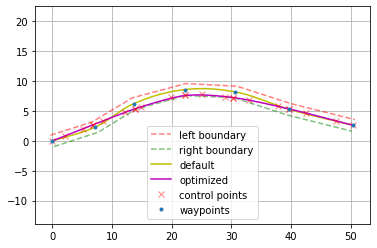

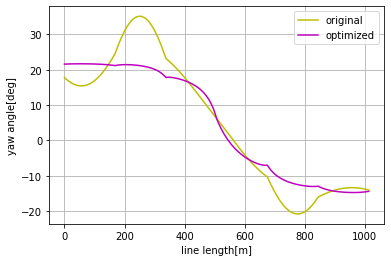

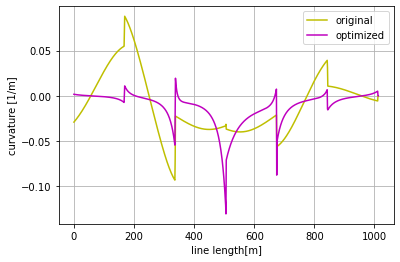

In [148]:
    # define input path
    ay = [0.0, 2.3, 6.25, 8.6, 8.2, 5.3, 2.6]
    ax = [0.0, 7.16, 13.68, 22.3, 30.64, 39.6, 50.4]
    boundary = 1.0

    spline = Spline(ax, ay, boundary)

    %time spline.optimize_min_cubic()

    # Path plot
    plt.subplots(1)
    plt.plot(spline.left_bound.x, spline.left_bound.y, '--r', alpha=0.5, label="left boundary")
    plt.plot(spline.right_bound.x, spline.right_bound.y, '--g', alpha=0.5, label="right boundary")
    plt.plot(spline.default_path.x, spline.default_path.y, '-y', label="default")
    plt.plot(spline.optimized_path.x, spline.optimized_path.y, '-m', label="optimized")
    plt.plot(spline.ctr_points.x, spline.ctr_points.y, 'xr', alpha=0.5, label="control points")
    plt.plot(spline.waypoints.x, spline.waypoints.y, '.', label="waypoints")
    plt.grid(True)
    plt.legend()
    plt.axis("equal")

    # Heading plot
    plt.subplots(1)
    plt.plot([np.rad2deg(iyaw) for iyaw in spline.default_path.yaw], "-y", label="original")
    plt.plot([np.rad2deg(iyaw) for iyaw in spline.optimized_path.yaw], "-m", label="optimized")
    plt.grid(True)
    plt.legend()
    plt.xlabel("line length[m]")
    plt.ylabel("yaw angle[deg]")

    # Curvature plot
    plt.subplots(1)
    plt.plot(spline.default_path.k, "-y", label="original")
    plt.plot(spline.optimized_path.k, "-m", label="optimized")
    plt.grid(True)
    plt.legend()
    plt.xlabel("line length[m]")
    plt.ylabel("curvature [1/m]")

    plt.show()